In [730]:
import pandas as pd
import requests
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer,RobustScaler
%matplotlib inline
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import  GradientBoostingRegressor,GradientBoostingClassifier,AdaBoostRegressor,BaggingRegressor,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDClassifier,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error ,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR,SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score ,confusion_matrix
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures


### Train Dataset

In [768]:
flag=False
train_dataset=pd.read_csv('INPUT/diamonds_train.csv',index_col=0)
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [750]:
train_dataset.shape

(40345, 10)

### Test Dataset

In [769]:
test_dataset=pd.read_csv('INPUT/diamonds_test.csv',index_col=0)


In [752]:
test_dataset.shape

(13449, 9)

# 1.Transformation of the categorical columns

In [770]:
cat_col=['cut', 'color', 'clarity']
train_dataset[cat_col]=train_dataset[cat_col].apply(LabelEncoder().fit_transform)
train_dataset.dtypes
train_dataset[cat_col]=train_dataset[cat_col]+1

In [771]:
test_dataset[cat_col]=test_dataset[cat_col].apply(LabelEncoder().fit_transform)
test_dataset[cat_col]=test_dataset[cat_col]+1



# 2. remotion of 0 values

In [772]:
train_dataset.loc[(train_dataset['x']==0) | (train_dataset['y']==0)]
train_dataset=train_dataset.loc[(train_dataset['x']>0) | (train_dataset['y']>0)]
train_dataset.loc[18027,'x']=train_dataset['x'].median()
train_dataset.loc[18027,'z']=train_dataset['z'].median()
train_dataset.loc[(train_dataset['z']==0)]
cols=['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',]
m=ElasticNet()
train_dataset_X=train_dataset.loc[0:10000,cols]
train_dataset_y=train_dataset.loc[0:10000,'z']
m.fit(train_dataset_X, train_dataset_y)
test_dataset1=train_dataset.loc[(train_dataset['z']==0),cols]                                 
y_pred=m.predict(test_dataset1)
train_dataset.loc[train_dataset['z']==0,'z']=y_pred
train_dataset.loc[(train_dataset['z']==0)]
#removing of outliars of 'y' and 'z' columns

train_dataset=train_dataset.loc[~(train_dataset['y']>30)|(train_dataset['z']>30)]


# 3. Price and categorical features Transformation

In [773]:
#applying log transformation to make the relation linear
flag=True
train_dataset['logprice']=np.log(train_dataset['price'])
train_dataset['price']=train_dataset['logprice']
train_dataset.drop('logprice',axis=1,inplace=True)

'''def trasf(x):
    return x**(1/3)
train_dataset['carat']=train_dataset['carat'].apply(trasf)
test_dataset['carat']=test_dataset['carat'].apply(trasf)
'''
#applying weight to the categorical features
train_dataset['cut/wt']=train_dataset['cut']/train_dataset['carat']
train_dataset['color/wt']=train_dataset['color']/train_dataset['carat']
train_dataset['clarity/wt']=train_dataset['clarity']/train_dataset['carat']
train_dataset = train_dataset.drop(['cut','color','clarity'], axis=1)

test_dataset['cut/wt']=test_dataset['cut']/test_dataset['carat']
test_dataset['color/wt']=test_dataset['color']/test_dataset['carat']
test_dataset['clarity/wt']=test_dataset['clarity']/test_dataset['carat']
test_dataset = test_dataset.drop(['cut','color','clarity'], axis=1)


# 4. New flag column 'category' to highlight the outliers

In [643]:
q_hi

2.04

In [644]:
q_h2 

1.51

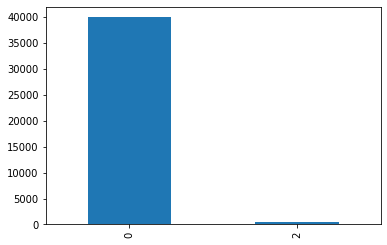

In [774]:

q_hi  = train_dataset["carat"].quantile(1)
q_h2  = train_dataset["carat"].quantile(0.99)

#train_dataset['category']=np.where(train_dataset['carat']<q_hi,0,1)#0=normal,1=outlier

def fillcat(x):
    if (x > q_h2)and(x<q_hi):
        return 2
    elif (x>q_hi):
        return 1
    else:
        return 0
train_dataset['category']=train_dataset['carat'].apply(fillcat)

train_dataset['category'].value_counts().plot.bar()


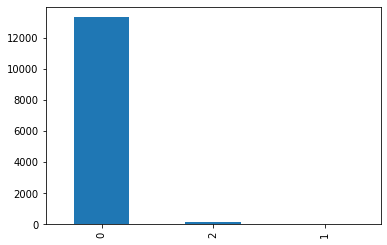

In [775]:
#test_dataset['category']=np.where(test_dataset['carat']<q_hi,0,1)#0=normal,1=outlier
test_dataset['category']=test_dataset['carat'].apply(fillcat)

test_dataset['category'].value_counts().plot.bar()



# 5.Prediction of the category column for the test_dataset 

In [460]:
'''#Accuracy test
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z']#, 'cut/wt', 'color/wt',
      #'clarity/wt']
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z']#, 'cut', 'color',
      #     'clarity']

train_dataset_X=train_dataset[cols]
train_dataset_y=train_dataset['category']

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_dataset_X, train_dataset_y, test_size = 0.2, random_state = 0)
models = {
    "GradientBoostingClassifier" : GradientBoostingClassifier(),
    "GradientBoostingClassifierP" : GradientBoostingClassifier(n_estimators=500, learning_rate=0.3),
    "RandomForestClassifier" : RandomForestClassifier(n_estimators=100),
    "Logistic" : LogisticRegression(),
    "SuperVectorC" : SVC()
}

for modelName, model in models.items():
    print(f"Training model: {modelName}")
    model.fit(X_train1, y_train1)
    y_pred=model.predict(X_test1)
    print(modelName,accuracy_score(y_test1, y_pred))
    print(confusion_matrix(y_test1, y_pred, normalize='true'))
#m =RandomForestClassifier(bootstrap=True,max_depth=70,
                        #    max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)

#m.fit(X_train1, y_train1)
#print("Training complete")
#y_pred=m.predict(X_test1)
#accuracy_score(y_test1, y_pred)

Training model: GradientBoostingClassifier
GradientBoostingClassifier 0.979300941993059
[[0.99657925 0.00342075]
 [0.8        0.2       ]]
Training model: GradientBoostingClassifierP
GradientBoostingClassifierP 0.9768220128904314
[[0.99125808 0.00874192]
 [0.67428571 0.32571429]]
Training model: RandomForestClassifier
RandomForestClassifier 0.979300941993059
[[0.99341188 0.00658812]
 [0.65714286 0.34285714]]
Training model: Logistic


/Users/silviaserafini/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic 0.9797967278135845
[[0.9953123 0.0046877]
 [0.72      0.28     ]]
Training model: SuperVectorC
SuperVectorC 0.9783093703520079
[[1. 0.]
 [1. 0.]]


'm =RandomForestClassifier(bootstrap=True,max_depth=70,\n                            max_features=\'auto\',min_samples_leaf=2,min_samples_split=2,n_estimators=700)\n\nm.fit(X_train1, y_train1)\nprint("Training complete")\ny_pred=m.predict(X_test1)\naccuracy_score(y_test1, y_pred)'

In [449]:
confusion_matrix(y_test1, y_pred, normalize='true')

array([[0.99569239, 0.00430761],
       [0.41142857, 0.58857143]])

In [472]:
'''if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
       'clarity/wt'
       ]
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity'
           ]

train_dataset_X=train_dataset[cols]
train_dataset_y=train_dataset['category']
 
m =RandomForestClassifier(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
    
m.fit(train_dataset_X, train_dataset_y)
print("Training complete")
y_pred=m.predict(test_dataset[cols])
test_dataset['category']=y_pred'''

Training complete


# 3.training of the 3 models m2= outliers(0.8-0.98) m1=outliers m0=normal

In [776]:
#first model for outliars 0.95-0.98
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
           'clarity/wt']
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity']
       
train_dataset_X1=train_dataset[train_dataset.category ==2][cols]
train_dataset_y1=train_dataset[train_dataset.category ==2]['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_dataset_X1, train_dataset_y1, test_size = 0.1, random_state = 0)
m2 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
'''#m2=GradientBoostingRegressor(n_estimators=800,max_depth=8,min_samples_split=25,min_samples_leaf=10,learning_rate=0.01, loss='ls')  


poly = PolynomialFeatures(degree=2)
poly_variables = poly.fit_transform(train_dataset_X1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_dataset_X1, train_dataset_y1, test_size = 0.3, random_state = 4)

m2 = LinearRegression()

m2.fit(X_train1, y_train1)
score = model.score(X_test1, y_test1)
'''
m2.fit(X_train1, y_train1)

print("Training complete")
if flag:
    y_test2=np.exp(y_test1)
    y_pred1=m2.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))
else:
    y_test2=np.exp(y_test1)
    y_pred1=m2.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))

Training complete
1899.7648468875086


In [ ]:
#second model for outliars 0.98-1
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
           'clarity/wt']
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity']
       
train_dataset_X1=train_dataset[train_dataset.category ==1][cols]
train_dataset_y1=train_dataset[train_dataset.category ==1]['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_dataset_X1, train_dataset_y1, test_size = 0.1, random_state = 0)
m1 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
    
#m1=HistGradientBoostingRegressor()
m1.fit(X_train1, y_train1)
print("Training complete")



In [686]:
if flag:
    y_test2=np.exp(y_test1)
    y_pred1=m1.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))
else:
    y_test2=np.exp(y_test1)
    y_pred1=m1.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))

2022.1808154195353


In [344]:
'''prova da eliminare
m0 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
train_dataset_X0=train_dataset[cols]
train_dataset_y0=train_dataset['price']

X_train0, X_test0, y_train0, y_test0 = train_test_split(train_dataset_X0, train_dataset_y0, test_size = 0.2, random_state = 0)
m0.fit(X_train0, y_train0)  
y_test2=np.exp(y_test0)
y_predout=m0.predict(X_test0)
y_pred2=np.exp(y_predout)
print(mean_squared_error(y_test2, y_pred2,squared=False))
 
y_test2=np.exp(y_test1)
y_predout=m0.predict(X_test1)
y_pred2=np.exp(y_predout)
print(mean_squared_error(y_test2, y_pred2,squared=False))'''

563.1688840090344


In [777]:
#third model, for normal values
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
           'clarity/wt'
           ]
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity'
           ]
train_dataset_X0=train_dataset[train_dataset.category ==0][cols]
train_dataset_y0=train_dataset[train_dataset.category ==0]['price']

X_train0, X_test0, y_train0, y_test0 = train_test_split(train_dataset_X0, train_dataset_y0, test_size = 0.2, random_state = 0)
m0 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
    
m0.fit(X_train0, y_train0)
print("Training complete")

Training complete


In [778]:
if flag:
    y_test3=np.exp(y_test0)
    y_pred0=m0.predict(X_test0)
    y_pred3=np.exp(y_pred0)
    print(mean_squared_error(y_test3, y_pred3,squared=False))
else:
    y_test3=np.exp(y_test0)
    y_pred0=m0.predict(X_test0)
    y_pred3=np.exp(y_pred0)
    print(mean_squared_error(y_test3, y_pred3,squared=False))

520.1713827720228


In [779]:
520*0.99+1899*0.01

533.79

# Final Prediction

In [780]:
m2==RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
  
'''m1==RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
 '''   
m0 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)

'''outliers=train_dataset.category ==1'''
outliers2=train_dataset.category ==2
normal=train_dataset.category ==0
train_dataset0= train_dataset[normal]
'''train_dataset1= train_dataset[outliers]'''
train_dataset2= train_dataset[outliers2]

m0.fit(train_dataset0[cols], train_dataset0['price'])
'''m1.fit(train_dataset1[cols], train_dataset1['price'])'''
m2.fit(train_dataset2[cols], train_dataset2['price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [781]:
'''y_predoutliers=m1.predict(test_dataset[cols])'''
y_prednormal=m0.predict(test_dataset[cols])
y_intermediate=m2.predict(test_dataset[cols])

'''usefirstmodel=test_dataset['category']==1'''
usesecondmodel=test_dataset['category']==2

y_pred=y_prednormal
'''y_pred[usefirstmodel]=y_predoutliers[usefirstmodel]'''
y_pred[usesecondmodel]=y_intermediate[usesecondmodel]
                              


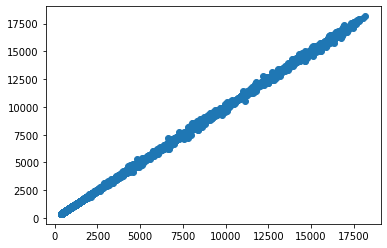

In [915]:
fil=pd.read_csv('submissionDoubleModelCarat98.csv')
y_pred2=np.exp(y_pred)
fil.shape
plt.scatter(tentative,fil['price'])

In [784]:
df=pd.DataFrame(y_pred2)
df=df.reset_index()
df.columns=('Id','price')

#df[['Id', 'price']].to_csv('submissionDouble533Model99.csv',index=False)


In [914]:
submission1=pd.read_csv('submissionDoubleModelCarat98.csv')
doublemodel=pd.read_csv('submissionAutoML.csv')

tentative=(submission1['price']+doublemodel['price'])/2

diff=(submission1['price']-doublemodel['price'])
#diff.sort_values(ascending=False)
filter1=(diff>1200) | (diff <-1200)
filter1.value_counts()
tentative[filter1]=submission1['price'][filter1]
filter1.value_counts()


False    13426
True        23
Name: price, dtype: int64

In [916]:
23/13

1.7692307692307692

In [917]:
doublemodel['price']=tentative
doublemodel[['Id', 'price']].to_csv('submissionHybridHope1.csv',index=False)


In [32]:
y_predl=None
predictions={}
y_testl=np.exp(y_test)
errors={"model":[],"Mean Square Error":[],"Root mean squared error":[],'mean_absolute_error':[]}
for modelName, model in models.items(): 
        y_pred = model.predict(X_test)
        y_predl=np.exp(y_pred)
        predictions[modelName]=y_predl
        errors["model"].append(modelName)
        errors["Mean Square Error"].append(np.sqrt(np.sum((np.subtract(pd.Series(y_predl),
                                                                       pd.Series(y_testl))**2))/len(y_predl)))
        
        errors['mean_absolute_error'].append(mean_absolute_error(y_testl,y_predl))
        errors["Root mean squared error"].append(mean_squared_error(y_testl, y_predl,squared=False))


pd.DataFrame(errors).sort_values(by='Mean Square Error')

In [52]:
y_predl=None
predictions={}
y_testl=np.exp(y_test)
errors={"model":[],"Mean Square Error":[],"Root mean squared error":[],'mean_absolute_error':[]}
for modelName, model in models.items(): 
        y_pred = model.predict(X_test)
        y_predl=np.exp(y_pred)
        predictions[modelName]=y_predl
        errors["model"].append(modelName)
        errors["Mean Square Error"].append(np.sqrt(np.sum((np.subtract(pd.Series(y_predl),
                                                                       pd.Series(y_testl))**2))/len(y_predl)))
        
        errors['mean_absolute_error'].append(mean_absolute_error(y_testl,y_predl))
        errors["Root mean squared error"].append(mean_squared_error(y_testl, y_predl,squared=False))


pd.DataFrame(errors).sort_values(by='Mean Square Error')

,model,Mean Square Error,Root mean squared error,mean_absolute_error
1,RandomForest100,2203.045774,497.406567,244.664689
0,RandomForest70,2203.443087,490.828548,241.555148
2,Bagging,2207.504468,518.969600,257.167797


# Training with the whole dataset

In [278]:
train_dataset.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'price', 'cut/wt', 'color/wt',
       'clarity/wt', 'category'],
      dtype='object')

In [53]:
#train themodel with the whole dataset
m=RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
#train_dataset_X=train_dataset[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'dimensions']]
train_dataset_X=train_dataset[['carat', 'depth', 'table', 'x', 'y', 'z',  'cut/wt', 'color/wt',
       'clarity/wt']]
'''train_dataset_X=train_dataset[['carat', 'depth', 'table', 'cut_Good', 'cut_Ideal',
       'cut_Premium', 'cut_Very Good', 'color_E', 'color_F', 'color_G',
       'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2', 'dimensions']]'''

train_dataset_y=train_dataset['price']
m.fit(train_dataset_X, train_dataset_y)
y_pred1=m.predict(test_dataset)

# Saving to CSV

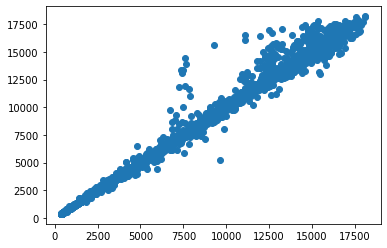

In [54]:
fil=pd.read_csv('submission.csv')
y_pred2=np.exp(y_pred1)
fil.shape
plt.scatter(y_pred2,fil['price'])

In [55]:
df=pd.DataFrame(y_pred2)
df=df.reset_index()
df.columns=('Id','price')
df[['Id', 'price']].to_csv('submission490meno2.csv',index=False)
